In [1]:
import pandas  as pd
import numpy as np
import os
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Embedding, Flatten, Input,MaxPooling1D,Dense, Dropout ,Conv1D
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import roc_auc_score
from nltk.corpus import wordnet 
import random
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
print('Loading data...')
data = pd.read_csv(r'train.csv')
test_data = pd.read_csv(r"test.csv")
test_labels = pd.read_csv(r"test_labels.csv")

Loading data...


In [3]:
test_data = test_data.merge(test_labels, how="right")
test_data_new = test_data[test_data['toxic']!=-1].reset_index(drop=True)


In [4]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [5]:
y=test_data_new.drop(["id","comment_text"], axis=1)
y_train=data.drop(["id","comment_text"], axis=1)

In [6]:
train_sentences = data.comment_text
test_sentences = test_data_new.comment_text

In [7]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


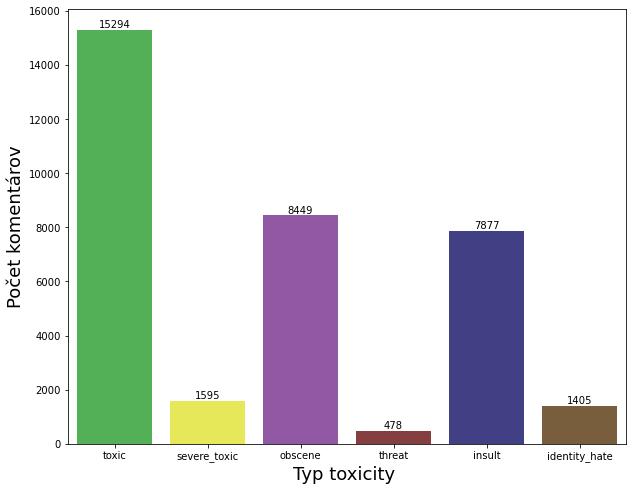

In [8]:
colors_list = ["green", "yellow", "purple",
               "blood", "deep blue", "brown", "azure"]

palette= sns.xkcd_palette(colors_list)

x=data.iloc[:,2:].sum()


plt.figure(figsize=(10,8))
ax= sns.barplot(x.index, x.values, alpha=0.8, palette=palette)
plt.ylabel('Počet komentárov', fontsize=18)
plt.xlabel('Typ toxicity ', fontsize=18)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [9]:
####Príprava dát do vhodnej podoby pre algotimus
EMBEDDING_DIM = 300 
max_features = 50000 ###jedinecnych slov
max_length = 510  ###maximalna dlzka sekvencií

In [10]:
###nacitanie slovnika GloVe
EMBEDDING_FILE = 'glove.840B.300d.txt' 
embeddings_index = {}
f = open(os.path.join('',EMBEDDING_FILE), encoding = "utf-8")
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [11]:
print("Tokenizacia")
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_sentences))
###kazda veta je sekvencia tvorená z čísel, ktoré charakterizujú slovo v texte
sequences_train = tokenizer.texts_to_sequences(train_sentences)
sequences_test = tokenizer.texts_to_sequences(test_sentences)

Tokenizacia


In [12]:
##zarovnanie sekvencí na rovnakú veľkosť
x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

In [13]:
word_index = tokenizer.word_index
print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Emmbedings matrix....
210338


(210338, 300)

In [15]:
model = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model.add(e)
model.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 510, 300)          63101400  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 510, 64)           19264     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 255, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16320)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16320)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2089088   
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

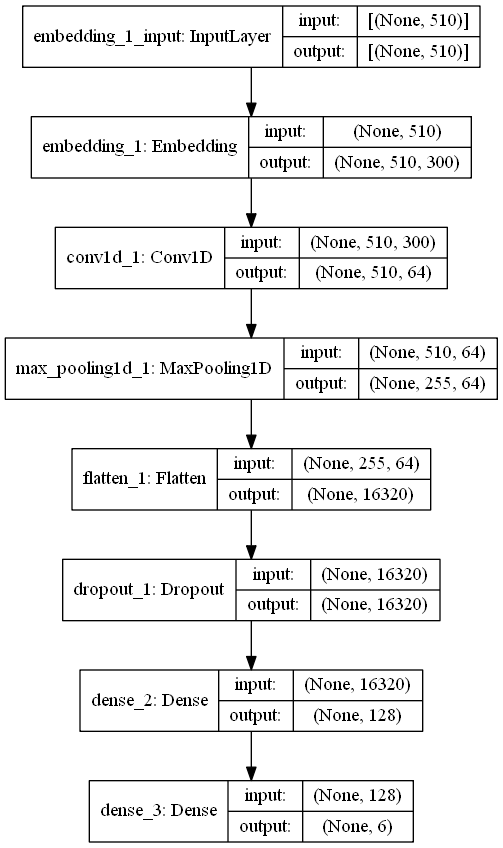

In [16]:
import graphviz
from tensorflow.keras import utils
import pydot
import pydotplus
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [17]:
saved_model= "model.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
print('Trénovanie modelu...')
history = model.fit(x_train_seq, y_train,epochs=3, batch_size=32,callbacks=[checkpoint],validation_split=0.1)


Trénovanie modelu...
Epoch 1/3
4488/4488 [==============================] - 3450s 768ms/step - loss: 0.0771 - acc: 0.8464 - val_loss: 0.0524 - val_acc: 0.9931

Epoch 00001: val_acc improved from -inf to 0.99311, saving model to model.hdf5
Epoch 2/3
4488/4488 [==============================] - 3283s 731ms/step - loss: 0.0432 - acc: 0.9663 - val_loss: 0.0540 - val_acc: 0.9898

Epoch 00002: val_acc did not improve from 0.99311
Epoch 3/3
4488/4488 [==============================] - 3286s 732ms/step - loss: 0.0348 - acc: 0.9352 - val_loss: 0.0623 - val_acc: 0.9415

Epoch 00003: val_acc did not improve from 0.99311


In [18]:
######VYHODNOTENIE
print("Vyhodnotenie...")

y_pred = model.predict(x_test_seq)
print('Roc auc score is {}'.format(roc_auc_score(y,y_pred)))
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Accuracy is {}'.format(accuracy_score(y,y_int)))
print(classification_report(y, y_int, zero_division=0))
print(multilabel_confusion_matrix(y, y_int))

Vyhodnotenie...
Roc auc score is 0.9677199064062849
Accuracy is 0.8688299102816593
              precision    recall  f1-score   support

           0       0.55      0.83      0.66      6090
           1       0.31      0.42      0.36       367
           2       0.60      0.76      0.67      3691
           3       0.30      0.05      0.09       211
           4       0.55      0.70      0.61      3427
           5       0.53      0.29      0.37       712

   micro avg       0.55      0.74      0.63     14498
   macro avg       0.47      0.51      0.46     14498
weighted avg       0.55      0.74      0.62     14498
 samples avg       0.07      0.07      0.07     14498

[[[53656  4232]
  [ 1016  5074]]

 [[63272   339]
  [  212   155]]

 [[58370  1917]
  [  874  2817]]

 [[63741    26]
  [  200    11]]

 [[58557  1994]
  [ 1031  2396]]

 [[63085   181]
  [  507   205]]]


<h4>Nahradenie synonymami<h4>

In [40]:
#####EDA 
###Nahradenie synonymami, definujeme počet slov 4, ktoré sa majú nahradiť synonymami
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)

def get_synonyms(word):
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)
def synonym_replacement(words, n=4):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: 
            break

    sentence = ' '.join(new_words)

    return sentence

In [41]:
###definujeme mnozinu, ktorá vyjadruje len texty troch najmenej početných tried teda, several_toxic,treat, identity_hate
toxic=train_sentences[(y_train.severe_toxic == 1) | (y_train.threat == 1) | (y_train.identity_hate == 1)]
###aplikujeme funkciu na nahradenie synonym
x_syn = toxic.apply(synonym_replacement)

In [42]:
#pridáme hodnotenie 1 pre všetky nové komentáre
y_syn=y_train[(y_train.severe_toxic == 1) | (y_train.threat == 1) | (y_train.identity_hate == 1)]

In [43]:
#spojime pôvodnú množinu a a novú vytvorenú množinu
x_syn=pd.concat([train_sentences,x_syn])
y_syn=pd.concat([y_train,y_syn])

In [44]:
print("Pocet nových vytvorených toxických komentárov")
print(len(toxic))

print("Počet toxických komentárov v celej množine pred rozšírením")
povodnetoxic=train_sentences[y_train.T[(y_train.T == 1)].any()]
print(len(povodnetoxic))

print("Počet toxických komentárov v celej množine po rozšírení")
novetoxic=x_syn[y_syn.T[(y_syn.T == 1)].any()]
print(len(novetoxic))



Pocet nových vytvorených toxických komentárov
2987
Počet toxických komentárov v celej množine pred rozšírením
16225
Počet toxických komentárov v celej množine po rozšírení
19212


In [45]:
###spojenú množinu musíme upraviť do vhondje podoby pre model, lebo je vo forme slovnej reprezentácie
print("Tokenizacia")
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(x_syn)
sequences_train = tokenizer.texts_to_sequences(x_syn)
sequences_test = tokenizer.texts_to_sequences(test_sentences)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

Tokenizacia


In [46]:
word_index = tokenizer.word_index
print('Najdenych %s jedinecnych tokenov.' %len (word_index))

print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Najdenych 210882 jedinecnych tokenov.
Emmbedings matrix....
210883


(210883, 300)

In [47]:
model = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model.add(e)
model.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
saved_model= "model_syn.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Training model...')
history = model.fit(x_train_seq, y_syn,epochs=3, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 510, 300)          63264900  
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 510, 64)           19264     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 255, 64)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 16320)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16320)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               2089088   
_________________________________________________________________
dense_13 (Dense)             (None, 6)                

In [48]:
######VYHODNOTENIE
print("Vyhodnotenie...")
model = load_model('model_syn.hdf5')
y_pred = model.predict(x_test_seq)
print('Roc auc skore je {}'.format(roc_auc_score(y,y_pred)))
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y,y_int)))
print(classification_report(y, y_int, zero_division=0))
print(multilabel_confusion_matrix(y, y_int))

Vyhodnotenie...
Roc auc skore je 0.9705240458815898
Úspešnosť je 0.8674544374628779
              precision    recall  f1-score   support

           0       0.53      0.88      0.66      6090
           1       0.39      0.19      0.26       367
           2       0.62      0.78      0.69      3691
           3       0.00      0.00      0.00       211
           4       0.61      0.66      0.63      3427
           5       0.61      0.13      0.22       712

   micro avg       0.57      0.73      0.64     14498
   macro avg       0.46      0.44      0.41     14498
weighted avg       0.57      0.73      0.62     14498
 samples avg       0.08      0.07      0.07     14498

[[[53161  4727]
  [  750  5340]]

 [[63500   111]
  [  297    70]]

 [[58563  1724]
  [  830  2861]]

 [[63766     1]
  [  211     0]]

 [[59090  1461]
  [ 1167  2260]]

 [[63205    61]
  [  616    96]]]


In [58]:
#kedže v predchádzajúcom modeli sme nedosiahli zlepšenie zmenili sme parameter 
###Nahradenie synonymami, definujeme počet slov 6, ktoré sa majú nahradiť synonymami
def get_synonyms(word):
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)
def synonym_replacement(words, n=6):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

###definujeme mnozinu, ktorá vyjadruje len texty troch najmenej početných tried teda, several_toxic,treat, identity_hate
toxic=train_sentences[(y_train.severe_toxic == 1) | (y_train.threat == 1) | (y_train.identity_hate == 1)]
###aplikujeme funkciu na nahradenie synonym
x_syn = toxic.apply(synonym_replacement)
#spojime pôvodnú množinu a a novú vytvorenú množinu
x_syn=pd.concat([train_sentences,x_syn])
y_syn=pd.concat([y_train,y_syn])

In [60]:
###spojenú množinu musíme upraviť do vhondje podoby pre model, lebo je vo forme slovnej reprezentácie
print("Tokenizacia")
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(x_syn)
sequences_train = tokenizer.texts_to_sequences(x_syn)
sequences_test = tokenizer.texts_to_sequences(test_sentences)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)
word_index = tokenizer.word_index

print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 

Tokenizacia
Emmbedings matrix....
210995


(210995, 300)

In [61]:
model = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model.add(e)
model.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()
saved_model= "model_syn6.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Training model...')
history = model.fit(x_train_seq, y_syn,epochs=3, batch_size=32,callbacks=[checkpoint],validation_split=0.1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 510, 300)          63298500  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 510, 64)           19264     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 255, 64)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 16320)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16320)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               2089088   
_________________________________________________________________
dense_19 (Dense)             (None, 6)                

In [62]:
######VYHODNOTENIE
print("Vyhodnotenie...")
model = load_model('model_syn6.hdf5')
y_pred = model.predict(x_test_seq)
print('Roc auc skore je {}'.format(roc_auc_score(y,y_pred)))
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y,y_int)))
print(classification_report(y, y_int, zero_division=0))
print(multilabel_confusion_matrix(y, y_int))

Vyhodnotenie...
Roc auc skore je 0.969352462040925
Úspešnosť je 0.8853981055987996
              precision    recall  f1-score   support

           0       0.61      0.79      0.68      6090
           1       0.39      0.36      0.37       367
           2       0.69      0.69      0.69      3691
           3       0.00      0.00      0.00       211
           4       0.69      0.54      0.60      3427
           5       0.73      0.20      0.31       712

   micro avg       0.64      0.65      0.64     14498
   macro avg       0.52      0.43      0.44     14498
weighted avg       0.64      0.65      0.63     14498
 samples avg       0.07      0.06      0.06     14498

[[[54763  3125]
  [ 1301  4789]]

 [[63400   211]
  [  234   133]]

 [[59162  1125]
  [ 1147  2544]]

 [[63767     0]
  [  211     0]]

 [[59722   829]
  [ 1591  1836]]

 [[63214    52]
  [  570   142]]]


<h4>Nahodné vymazanie <h4>

In [49]:
####NAHODNE VYMAZANIE

def random_deletion(words, p=0.15):
    words = words.split()
     # zjavne, ak je iba jedno slovo,  nevymazeme ho
    if len(words) == 1:
        return words
    
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence
###opakujeme rovnaký postup ako v predchádzajúcej metóde
toxic=train_sentences[(y_train.severe_toxic == 1) | (y_train.threat == 1) | (y_train.identity_hate == 1)]
x_del = toxic.apply(random_deletion)
y_del=y_train[(y_train.severe_toxic == 1) | (y_train.threat == 1) | (y_train.identity_hate == 1)]
x_random_del=pd.concat([train_sentences,x_del])
y_random_del=pd.concat([y_train,y_del])


In [50]:
print("Tokenizacia")
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(x_syn)

sequences_train = tokenizer.texts_to_sequences(x_random_del)
sequences_test = tokenizer.texts_to_sequences(test_sentences)

x_train_seq = pad_sequences(sequences_train, maxlen=max_length) 
x_test_seq = pad_sequences(sequences_test, maxlen=max_length)

word_index = tokenizer.word_index

print("Emmbedings matrix....")
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(num_words)
embedding_matrix.shape 


Tokenizacia
Emmbedings matrix....
210883


(210883, 300)

In [51]:
model = Sequential()
e = Embedding(num_words,  EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length)
model.add(e)
model.add(Conv1D(filters=64, kernel_size=1, padding='valid', activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 510, 300)          63264900  
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 510, 64)           19264     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 255, 64)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 16320)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16320)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               2089088   
_________________________________________________________________
dense_15 (Dense)             (None, 6)                

In [52]:
saved_model = "model_del.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

print('Training model...')
history = model.fit(x_train_seq, y_random_del,epochs=3, batch_size=32,callbacks=[checkpoint],validation_split=0.1)


Training model...
Epoch 1/3
4572/4572 [==============================] - 3123s 683ms/step - loss: 0.0764 - acc: 0.8648 - val_loss: 0.1568 - val_acc: 0.9772

Epoch 00001: val_acc improved from -inf to 0.97718, saving model to model_del.hdf5
Epoch 2/3
4572/4572 [==============================] - 3344s 731ms/step - loss: 0.0430 - acc: 0.9661 - val_loss: 0.1485 - val_acc: 0.9740

Epoch 00002: val_acc did not improve from 0.97718
Epoch 3/3
4572/4572 [==============================] - 3195s 699ms/step - loss: 0.0345 - acc: 0.9230 - val_loss: 0.1450 - val_acc: 0.9230

Epoch 00003: val_acc did not improve from 0.97718


In [54]:
######VYHODNOTENIE
print("Vyhodnotenie...")
model = load_model('model_del.hdf5')
y_pred = model.predict(x_test_seq)
print('Roc auc skore je {}'.format(roc_auc_score(y,y_pred)))
y_int = np.zeros_like(y_pred)
y_int[y_pred > 0.5] = 1
print('Úspešnosť je {}'.format(accuracy_score(y,y_int)))
print(classification_report(y, y_int, zero_division=0))
print(multilabel_confusion_matrix(y, y_int))


Vyhodnotenie...
Roc auc skore je 0.9656277744413778
Úspešnosť je 0.8698615148957454
              precision    recall  f1-score   support

           0       0.54      0.86      0.67      6090
           1       0.35      0.35      0.35       367
           2       0.63      0.77      0.70      3691
           3       0.00      0.00      0.00       211
           4       0.54      0.73      0.62      3427
           5       0.00      0.00      0.00       712

   micro avg       0.56      0.74      0.64     14498
   macro avg       0.34      0.45      0.39     14498
weighted avg       0.53      0.74      0.61     14498
 samples avg       0.07      0.07      0.07     14498

[[[53501  4387]
  [  841  5249]]

 [[63375   236]
  [  238   129]]

 [[58649  1638]
  [  850  2841]]

 [[63767     0]
  [  211     0]]

 [[58395  2156]
  [  932  2495]]

 [[63263     3]
  [  712     0]]]
